[**Speech Accent Arhive Mandarin Subcorpus**](https://accent.gmu.edu/browse_language.php?function=find&language=mandarin)

## Weighted Convolution Relevance ##

Reference: [Sun et al. (2023)](https://ieeexplore.ieee.org/document/10143311/)

In [1]:
import transformers
from transformers import Wav2Vec2ForCTC, AutoTokenizer, AutoFeatureExtractor
import torch
import librosa
import librosa.display
from IPython.display import Audio
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import jiwer
from scipy import signal

print(transformers.__version__)

4.28.0.dev0


In [2]:
PATH_TO_DATA = "/home/sl12/SAA/recordings/chopped_recordings/slabs/mandarin33_slabs.mp3"
DEVICE = "cuda:0"

In [3]:
input_audio, sr = librosa.load(PATH_TO_DATA, sr=16000)
Audio(input_audio, rate=16000)

/home/sl12/.conda/envs/speech2image/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [4]:
### LOAD AUDIO AND TRANSCRIPT ###
transcription = "five thick slabs of blue cheese"

In [5]:
### LOAD PROCESSOR AND MODEL ###
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

### LOAD AUDIO INPUTS ###
inputs = feature_extractor(input_audio, sampling_rate=16000, return_tensors="pt")
inputs["input_values"] = inputs["input_values"].cuda()

### PASS THROUGH MODEL ###
output = model(**inputs, output_attentions=True)

### PREDICTED TRANSCRIPTION ###
logits = output.logits
predicted_ids = torch.argmax(logits[0], dim=-1)
outputs = tokenizer.decode(predicted_ids, output_word_offsets=True, output_char_offsets=True)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
outputs[0]

'FIVE THICK SLAPS OF BLUE CHEESE'

In [7]:
char_offsets = [
    {
        "char": d["char"],
        "start": d["start_offset"],
        "end": d["end_offset"],
    }
    for d in outputs.char_offsets
]

word_offsets = [
    {
        "word": d["word"],
        "start": d["start_offset"],
        "end": d["end_offset"],
    }
    for d in outputs.word_offsets
]

In [8]:
char_offsets[10:18] #char

[{'char': ' ', 'start': 45, 'end': 47},
 {'char': 'S', 'start': 47, 'end': 49},
 {'char': 'L', 'start': 51, 'end': 52},
 {'char': 'A', 'start': 56, 'end': 57},
 {'char': 'P', 'start': 59, 'end': 60},
 {'char': 'S', 'start': 62, 'end': 64},
 {'char': ' ', 'start': 64, 'end': 67},
 {'char': 'O', 'start': 67, 'end': 68}]

In [9]:
word_offsets

[{'word': 'FIVE', 'start': 16, 'end': 29},
 {'word': 'THICK', 'start': 35, 'end': 44},
 {'word': 'SLAPS', 'start': 47, 'end': 64},
 {'word': 'OF', 'start': 67, 'end': 69},
 {'word': 'BLUE', 'start': 73, 'end': 83},
 {'word': 'CHEESE', 'start': 87, 'end': 103}]

In [10]:
### HADAMARD & AVERAGE ###
score = torch.transpose(logits, 1, 2)
score_argmax_col, _ = torch.max(score, dim=1) # 1 * 255
grad_list = []

# pre-calculate gradient
for j in range(12): # By each attention layer
    attention = output.attentions[j]
    grad_layer = []
    for idx in range(56, 58): # By each token corresponds to the target character
        grad_token = torch.autograd.grad(score_argmax_col[0][idx], attention, retain_graph=True) # dS/dA
        grad_layer.append(grad_token) # list of gradients in a single attention layer
    grad_list.append(grad_layer) # list of gradients in each attention layer
    
print("GRAD_LIST: ", len(grad_list)) # should be 12

GRAD_LIST:  12


In [11]:
E_list = np.zeros((len(grad_token[0][0][0]), len(grad_token[0][0][0])))
### WEIGHTED ATTENTION RELEVANCE CALCULATION ###
  
# for idx in range(len(score_argmax_col[0])): # By each token
order = 0
for idx in range(56, 58):
    # print("GRAD: ", grad)
    for k in range(12): # By each attention layer
        att = output.attentions[k]
        grad = grad_list[k][order]
        avg = [] 
        for i in range(12): # By each multi-attention head
            att_tmp = att[0][i][idx].cpu().detach().numpy()
            grad_tmp = grad[0][0][i][idx].cpu().detach().numpy()
            tmp = np.maximum(0, np.multiply(att_tmp, grad_tmp))
            avg.append(tmp)
        E_mat = sum(avg) / len(avg) # 1 * 255
    order += 1
    E_list[idx, :] = E_mat

<AxesSubplot:>

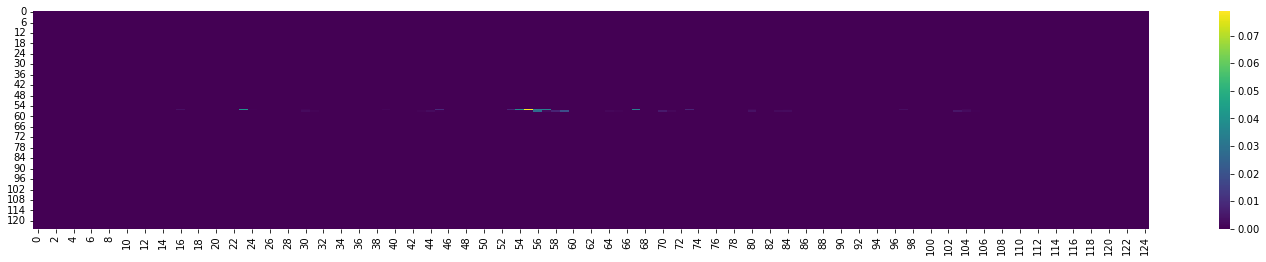

In [12]:
plt.figure(figsize=(25,4))
sns.heatmap(E_list, cmap="viridis") #YlGnBu

“five thick slabs of blue cheese”


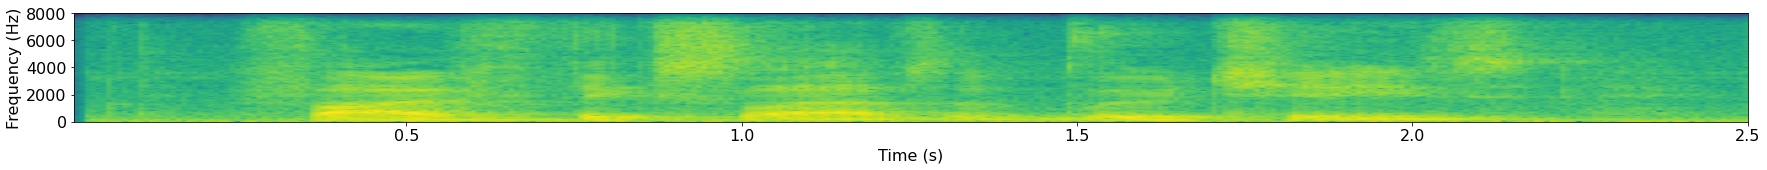

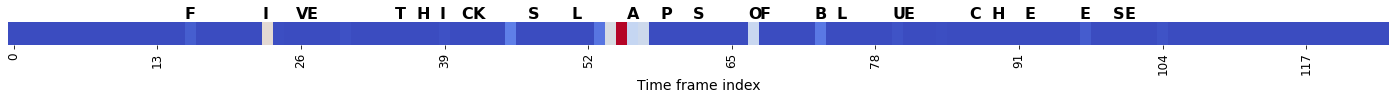

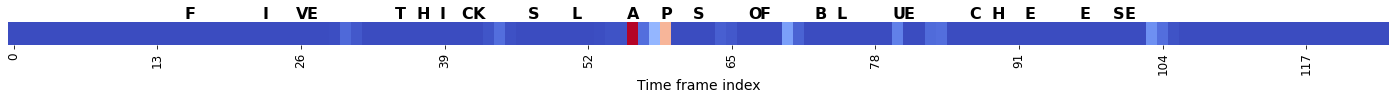

In [13]:
print("“five thick slabs of blue cheese”")
fig2, ax = plt.subplots(figsize=(30,2))
plt.specgram(input_audio,Fs=sr)
# plt.title("Spectrogram of the input audio", fontsize=18)
plt.ylabel('Frequency (Hz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

for ind in range(56, 58):
    fig, ax1 = plt.subplots(1, figsize=(21,2))
    fig.tight_layout(pad=5.0)
    sns.heatmap(np.array([E_list[ind, :]]), ax=ax1, cmap="coolwarm", cbar=False) #YlGnBu
    # fig.suptitle(f"Visualization of 'A' in 'SLABS'", fontsize=18, fontweight='bold')
    for i in char_offsets:
        word = i["char"]
        point = i["start"]
        endpoint = i["end"]+1
        ax1.text(point, -0.01, word.upper(), ha="left", va="bottom", size=16, weight="bold", in_layout=True)
    plt.xlabel('Time frame index', fontsize=14)
    plt.xticks(fontsize=12)
    plt.locator_params(axis='x', nbins=10)
    plt.tick_params(left = False, labelleft = False)
    plt.show()